<!-- \title{Jesús Rafael Valverde Coria \\ \small{Laboratorio de Física Contemporánea I} }
\date{19 de noviembre de 2020}
\maketitle -->

# Projecto - Probabilidad, Ajuste de Modelos y Método Monte Carlo

El archivo "data.txt" muestra la distribución de la gente en un andén del metro a lo largo de un día. La estación del metro tiene tres entradas al andén colocadas a 30, 70 y 120 metros respecto del inicio del andén, el cual mide 150 metros en total.

La distribución se obtuvo contando a todas las personas distribuidas cada 1 metro de principio a fin. De esta forma se obtiene la siguiente distribución con 150 "bins".


Objetivo: Graficar la distribución y responder las preguntas que se muestran más adelante.

In [26]:
# BLoque para importar librerias y definir el thema de graficación y del notebook
!jt -t chesterish -tfs 18 -fs 16 -nfs 16  -cursw 2 -cursc r -cellw 90% -T -mathfs 110 -lineh 150
plot_theme = 'chesterish'


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Markdown as md
from IPython.display import display, Math # Formato LaTeX en print

# LaTeX
plt.rcParams['text.usetex'] = True
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

rosa = '#f21d64'
data = np.loadtxt("data.txt",unpack=True)
binscenters  = data[0] # Centro de los bins
muestra      = data[1] # Datos de la distribución
bin_width    = 1 # El conteo se hace cada 1 metro


from jupyterthemes import jtplot
jtplot.style(theme=plot_theme, context = 'poster', ticks = True, grid = False, fscale=2.)

font = {'family': 'serif',
        'weight': 'normal',
        'fontstyle': 'italic',
        }

In [2]:
#Defino los datos dados en un dataframe llamado df
d = {'distancias': binscenters, 'frecuencias': muestra}
df = pd.DataFrame(data=d)

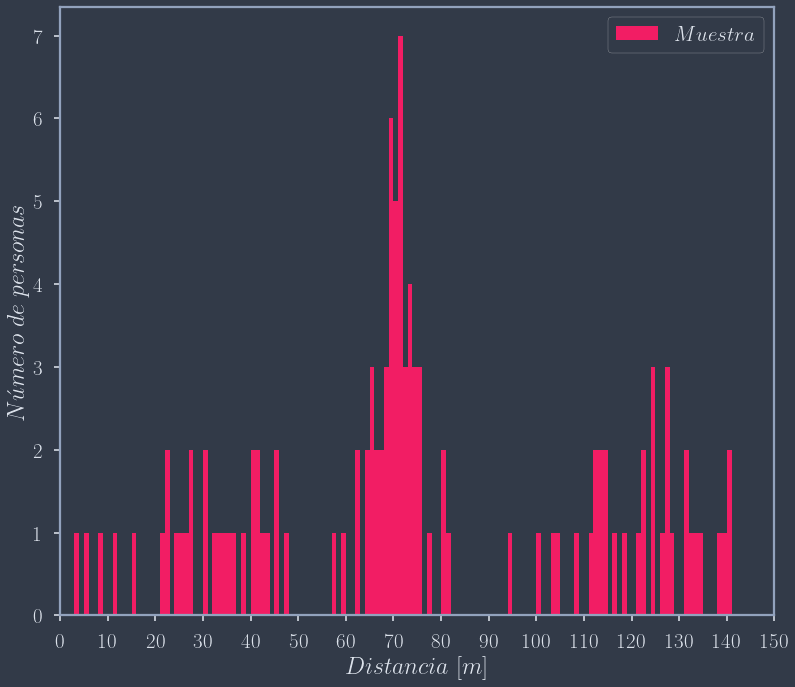

In [3]:
#Grafico de la muestra dada
plt.bar(df['distancias'], df['frecuencias'], width=bin_width, color=rosa, label=r'$Muestra$')
plt.xlabel(r'$Distancia \;[m]$', fontdict = font)
plt.ylabel(r'$N\acute{u}mero \;de \;personas$', fontdict = font)
plt.xlim(0,150)
plt.xticks(np.round(np.arange(0,160,10),0))
plt.legend()
plt.show()

Esta distribución es una muestra representativa de lo que sucede todos los días a lo largo del año, pero sigue siendo sólo un día el que se muestra. Lo ideal sería realizar el conteo durante todos los días para así tener un estimado de la distribución en el año. Sin embargo, esto último resulta imposible, al menos en la práctica.

Preguntas:

- ¿Cuántas personas hubo en la estación ese día?
- ¿Cuál es la probabilidad de encontrar 1 persona entre los 100 y 110 metros de la estación durante este día?.
- ¿Podrías estimar de alguna forma cuál sería la probabilidad de encontrar 1 persona entre los 100 y 110 metros, pero durante todo el año?
- ¿Cuál es la posición más probable para encontrar a una persona (valor esperado) en el día? ¿Y a lo largo del año?
- ¿Qué conclusiones puedes dar? ¿Es posible dar una estimación correcta de estos resultados a lo largo del año? ¿Qué cambiarías sobre tus suposiciones

Tips:

1) Supón todo lo que tengas que suponer, pero arguméntalo.

2) Usa cualquiera de las cosas que hayamos visto (checa los notebooks Probabilidad.ipynb, Pi_Estimation.ipynb, Ajuste de Modelo - MC.ipynb).

3) Es conveniente ajustar un modelo a los datos.

4) Nota que la distribución que tienes no está normalizada, por lo que no es una PDF todavía.

5) Recuerda que 
$$ 
\int_0^{150} p(x) \, \mathrm{d}x = 1.
$$
6) Calcula la función acumulativa (CDF). Esta función debe valer 1 en 150, con esto sabrás si tu PDF está bien normalizada.

7) Para las preguntas sobre cuál sería la probabilidad a lo largo del año, te recomiendo realizar 365 simulaciones Monte Carlo (una por cada día del año) asumiendo una distribución que se acople a los datos que tienes (punto 3) y obteniendo una muestra distinta (sample, distribución) de N personas para cada día. Puedes asumir que cada día hay la misma cantidad N de personas o, si quieres, asumir una forma más complicada como, por ejemplo, que en días festivos no hay tanta gente como en un viernes de quincena, o simplemente asumir más personas.

\section{Soluciones:}

\subsection{1.- ¿Cuántas personas hubo en la estación ese día?}

El array "muestra" contiene las frecuencias asociadas a cada bin, esto es el número de personas que están en cada intervalo de un metro centrado en los valores "binscenter". Por lo tanto, el número total de personas es simplemente la suma de esas frecuencias:

In [4]:
N = df['frecuencias'].sum()
md(f'El número de personas que hubo ese día en el metro según la muestra dada es {N}')

El número de personas que hubo ese día en el metro según la muestra dada es 115.0

\subsection{2.- ¿Cuál es la probabilidad de encontrar una persona entre los 100 y 110 metros de ese día?}

Voy a usar curve_fit para ajustar a la distribución una función que sea una suma de tres gaussianas. 

Empiezo calculando los parámetros iniciales que srvirán para el prior del ajuste:

In [5]:
# defino condiciones para separar los datos en tres grupos asociados a cada uno de los picos gaussianos
lim1 = 50; lim2 = 97
cond1 = df['distancias'] < lim1
cond2 = (df['distancias'] > lim1) & (df['distancias'] < lim2)
cond3 = df['distancias'] > lim2

#Defino las medias de cada uno de los picos
mu1 = df[cond1]['distancias'].mean()
mu2 = df[cond2]['distancias'].mean()
mu3 = df[cond3]['distancias'].mean()

#Defino las desviaciones estándar de cada grupo
sigma1 = df[cond1]['distancias'].std()
sigma2 = df[cond2]['distancias'].std()
sigma3 = df[cond3]['distancias'].std()

#Defino las amplitudes de cada pico como la máxima frecuencia
A1 = df[cond1]['frecuencias'].max()
A2 = df[cond2]['frecuencias'].max()
A3 = df[cond3]['frecuencias'].max()

Voy a suponer que la función que se ajusta a los datos es una suma de tres gaussianas de la forma:

$$f(x) = A_1\exp{ \left( -\frac{(x-\mu_1)^2}{2\sigma_1^2} \right)} + A_2 \exp{\left( -\frac{(x-\mu_2)^2}{2\sigma_2^2} \right)} +A_3\exp{ \left(-\frac{(x-\mu_3)^2}{2\sigma_3^2} \right)}$$

usando como aproximación inicial los parámetros ya calculados.

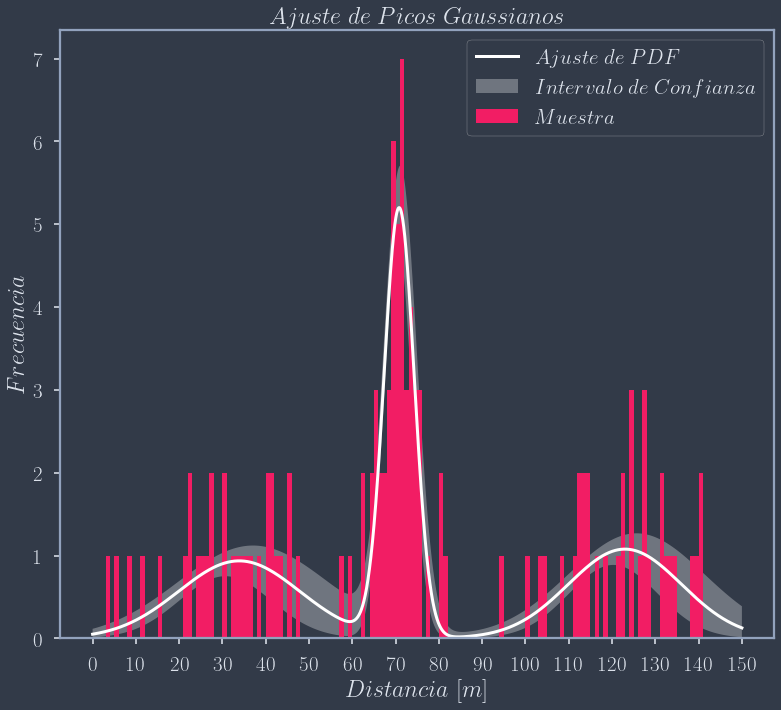

In [6]:
# from scipy.optimize import curve_fit
from scipy import optimize

#Definición de función por ajustar
def gaussianas(x, A1, A2, A3, mu1, mu2, mu3, sigma1, sigma2, sigma3):
    return (A1 * np.exp(-1.0 * (x - mu1)**2 / (2 * sigma1**2)) +
            A2 * np.exp(-1.0 * (x - mu2)**2 / (2 * sigma2**2)) +
            A3 * np.exp(-1.0 * (x - mu3)**2 / (2 * sigma3**2)))

p0 = [A1, A2, A3, mu1, mu2, mu3, sigma1, sigma2, sigma3] #definicion del prior
popt, pcov = optimize.curve_fit(gaussianas, xdata = df['distancias'], ydata = df['frecuencias'], p0=p0)

#Ploteo de la muestra y del fit
xspace = np.linspace(0, 150, 100000)
plt.bar(df['distancias'], df['frecuencias'], width=bin_width, color=rosa, label=r'$Muestra$')
plt.plot(xspace, gaussianas(xspace, *popt), color='white', linewidth=3, label=r'$Ajuste \; de \;PDF$')


#Ploteo del intervalo de confianza
psigma = np.sqrt(np.diag(pcov)) #Cálculo de la desviación estándar de los parámetros del fit
popt_max = popt + psigma; popt_min = popt - psigma  #Defino los parámetros de las gaussianas que delimitan los intervalos de confianza
gauss_min = gaussianas(xspace, *popt_min) #Cota inferior del intervalo de confianza
gauss_max = gaussianas(xspace, *popt_max) #Cota superior del intervalo de confianza
plt.fill_between(xspace, gauss_min, gauss_max, 
                 where=(gauss_max > gauss_min), facecolor='white', alpha=0.3, label = r'$Intervalo\; de \; Confianza$')

plt.xticks(np.arange(0,160,10))
plt.xlabel(r'$Distancia$ $[m]$')
plt.ylabel(r'$Frecuencia$')
plt.title(r'$Ajuste\; de \;Picos\; Gaussianos$')
plt.legend()
plt.show()

El ajuste aún no está normalizado, por lo que falta encontrar una constante $C$ tal que
$$ 
\int_0^{150} C p(x) \, \mathrm{d}x = 1.
$$

$$\implies C = \frac{1}{\int_0^{150}p(x)\, \mathrm{d}x } $$

Utilizaré la regla compuesta de Simpson para hacer el cálculo de las integrales. Según el libro de \textit{Análisis Numérico} de Burden: 

\textbf{Teorema: } 
Sean $f\epsilon C^4[a,b])$, $n$ par, $h = (b-a)/n$ y $x_j = a + jh$ para cada $j = 1,...n$. Existe $\mu\epsilon(a,b))$ tal que la regla compuesta de Simpson puede escribirse con su término de error como
\begin{equation}
\int_a^bf(x)\mathrm{d}x = \frac{h}{3}\left( f(a) +2\sum_{j=1}^{(n/2)-1}f(x_{2j}) + 4\sum_{j=1}^{n/2}f(x_{2j-1}) + f(b)\right) - \frac{b-a}{180}h^4f^{(4)}(\mu)
\end{equation}


In [7]:
#Defino función para integrar usando la regla de simpson
def integra(f,a,b,n=10000):
    h = (b-a)/n
    s_par = 0. ; s_impar = 0.
    for i in range(1,n):
        x = a + i*h
        if i%2 == 0:
            s_par = s_par + f(x)
        else:
            s_impar = s_impar + f(x)
    
    return (h/3)*(f(a) + 2*s_par + 4*s_impar + f(b))         

In [8]:
def normaliza(f, popt):
    #Redefino la función ajustada a los datos como una función que ya solo depende de x para usarla en la función integradora
    ajuste = lambda x: f(x, *popt)

    #Calculo la constante de normalización
    c_normalizacion = 1/integra(ajuste, 0, 150, n = 10000)

    #Redefino la función de ajuste pero ya normalizada, lo que ya sería mi PDF
    p = lambda x: c_normalizacion*gaussianas(x, *popt)
    
    return p, c_normalizacion

p, c_normalizacion = normaliza(gaussianas, popt)

#Y ahora si la integral de la distribución en toda la muestra vale 1: 
md(f'La integral de p a lo largo de toda la muestra es: $$\int_{{0}}^{{150}} p(x)\;\mathrm{{d}}x= {round(integra(p,0,150),1)}$$')

La integral de p a lo largo de toda la muestra es: $$\int_{0}^{150} p(x)\;\mathrm{d}x= 1.0$$

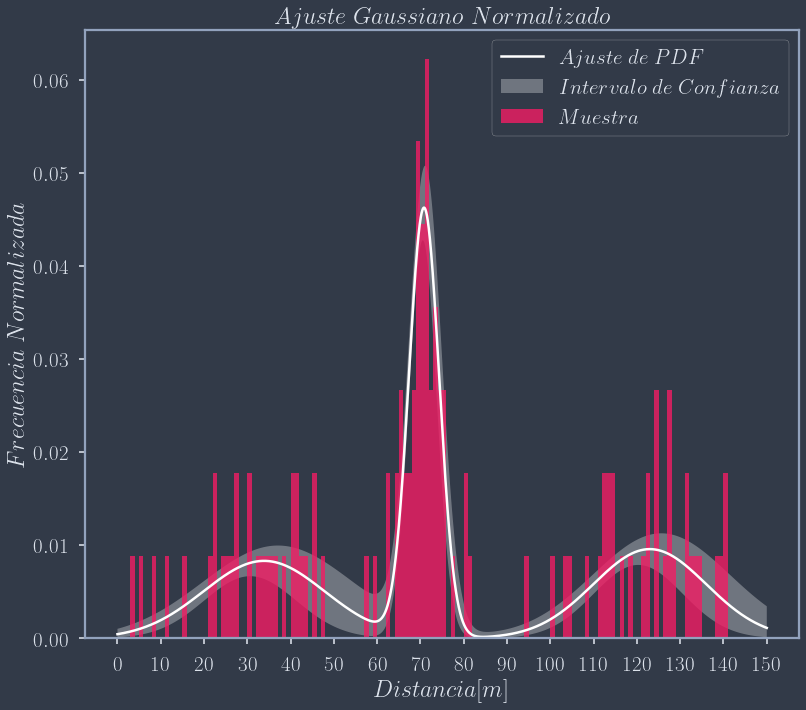

In [9]:
#Ploteo de nuevo la muestra y el ajuste ya normalizados
xspace = np.linspace(0, 150, 10000)
plt.bar(df['distancias'], c_normalizacion*df['frecuencias'], width=bin_width, color=rosa, label=r'$Muestra$', alpha = 0.8)
plt.plot(xspace, p(xspace), color='white', linewidth=2.5, label=r'$Ajuste \; de \;PDF$')
plt.xticks(np.arange(0,160,10))


#Ploteo del intervalo de confianza
gauss_min = c_normalizacion*gaussianas(xspace, *popt_min) #Cota inferior del intervalo de confianza
gauss_max = c_normalizacion*gaussianas(xspace, *popt_max) #Cota superior del intervalo de confianza
plt.fill_between(xspace, gauss_min, gauss_max, 
                 where= (gauss_max > gauss_min), facecolor='white', alpha=0.3, label = r'$Intervalo\; de \; Confianza$')

plt.xlabel('$Distancia [m]$')
plt.ylabel('$Frecuencia \;Normalizada$')
plt.title('$Ajuste \;Gaussiano \;Normalizado$')
plt.legend()
plt.show()

In [10]:
md(f'La probabilidad de encontrar una persona entre los 100 y 110 metros el día que se tomó la muestra es: '
    f'$$P(100\leq x\leq 110) = \int_{{100}}^{{110}}p(x)\;\mathrm{{d}}x  =  {round(integra(p, 100, 110), 5)}$$')

La probabilidad de encontrar una persona entre los 100 y 110 metros el día que se tomó la muestra es: $$P(100\leq x\leq 110) = \int_{100}^{110}p(x)\;\mathrm{d}x  =  0.03795$$

\subsection{3.- ¿Podrías estimar de alguna forma cuál sería la probabilidad de encontrar 1 persona entre los 100 y 110 metros, pero durante todo el año?}

Voy a suponer que durante todo el año, el comportamiento de la gente fue más o menos igual, por lo que usando el fit ya encontrado, generaré más distribuciones de datos, una por cada día del año, y para cada nueva distribución generada, se obtendrán su respectivo nuevo ajuste. El promedio de estos fit's se supondrá como el comportamiento general de la distribución de la gente durante todo el año.

In [11]:
n_sim = 365  #No. de simulaciones Monte Carlo, una por cada día del año
n_personas = 150 #No. de personas que utilizan el metro en cada día

def sim_mc(n_sim=365, n_personas=150, title=r'$Ajuste \; Gaussiano \;Monte \;Carlo$'):
    # Empieza el MC
    FitParams = np.array([])
    for i in range(n_sim):
        x_sim = np.random.uniform(0., 150., size=n_personas) # ojo, esto es otro prior porque no tiene que ser uniforme
        y_gen = gaussianas(x_sim,*popt)   #Ajuste anterior como prior de las simulaciones

        yerrors = np.abs((gaussianas(x_sim, *popt_min) - gaussianas(x_sim, *popt_max))/2) #Errores que usaré como media para los errores
                                                                                          # sintéticos creados a partir del fit original
        y_sim = y_gen + np.random.normal(scale=yerrors,size=n_personas)    # Creo los datos sintéticos usando como media el error experimental real

        try:
            vsims, acova = optimize.curve_fit(gaussianas,x_sim,y_sim, p0=p0)
        except:
            dumdum=1
            continue # Pasa al siguiente loop

        if np.size(FitParams) < 1:
            FitParams = np.copy(vsims)
        else:
            FitParams = np.vstack(( FitParams, vsims ))
    
    #Obtengo el promedio y la desviación estándar de cada parámetro
    med_A1 = np.median(FitParams[:,0]); std_A1 = np.std(FitParams[:,0]) 
    med_A2 = np.median(FitParams[:,1]); std_A2 = np.std(FitParams[:,1]) 
    med_A3 = np.median(FitParams[:,2]); std_A3 = np.std(FitParams[:,2]) 

    med_mu1 = np.median(FitParams[:,3]); std_A1 = np.std(FitParams[:,3]) 
    med_mu2 = np.median(FitParams[:,4]); std_A2 = np.std(FitParams[:,4]) 
    med_mu3 = np.median(FitParams[:,5]); std_A3 = np.std(FitParams[:,5]) 

    med_sigma1 = np.median(FitParams[:,6]); std_A1 = np.std(FitParams[:,6]) 
    med_sigma2 = np.median(FitParams[:,7]); std_A2 = np.std(FitParams[:,7]) 
    med_sigma3 = np.median(FitParams[:,8]); std_A3 = np.std(FitParams[:,8])
    
    #Grafico todos los fits obtenidos
    inds = range(len(FitParams))
    fig, ax = plt.subplots()
    
    x_fine = np.linspace(0,150,1000)
    for ind in inds:
        params = FitParams[ind]
        plots = ax.plot(x_fine, gaussianas(x_fine,*params), color = 'C1', alpha=0.2)
    
    #Grafico el fit "promedio"
    params_promedios = [med_A1, med_A2, med_A3, med_mu1, med_mu2, med_mu3, med_sigma1, med_sigma2, med_sigma3]
    ax.plot(x_fine,gaussianas(x_fine, *params_promedios), color = 'C1', alpha=0.9, label = r'$Tiradas\; MC$')
    ax.plot(x_fine,gaussianas(x_fine, *params_promedios), color = 'white', label = r'$Ajuste\; Promedio$')
    
    
    gauss_min = gaussianas(x_fine, *popt_min) #Cota inferior del intervalo de confianza
    gauss_max = gaussianas(x_fine, *popt_max) #Cota superior del intervalo de confianza
    ax.fill_between(x_fine, gauss_min, gauss_max, where=(gauss_max > gauss_min), 
                    facecolor='white', alpha=0.2, label = '$Intervalo\; de \; Confianza$')
    
    ax.set_xlabel(r'$Distancia$  $[m]$')
    ax.set_ylabel(r'$Frecuencia$')
    ax.set_title(title)
    ax.set_xlim(0,150)
    ax.set_xticks(np.arange(0,160, 10))
    ax.set_ylim(0,6)
    plt.legend()
    plt.show()
    
    return params_promedios, fig;

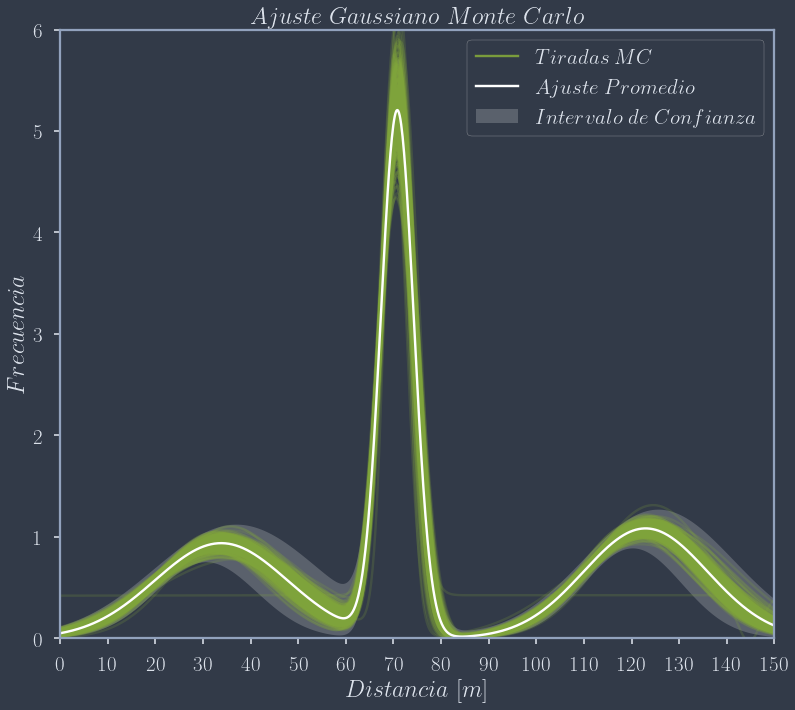

In [12]:
params_prom, fig = sim_mc(n_sim=365, n_personas=150)

Ya tengo el ajuste promedio que utilizaré para describir cualquier día del año. Sólo falta, de nuevo, normalizarlo para que sea una PDF.

In [13]:
p_prom, cte_norm = normaliza(gaussianas,params_prom)

In [14]:
md(f' La probabilidad de encontrar a una persona  entre los 100 y 110m para cualquier día del año es: '
   f'$$P(100\leq x\leq 110) = \int_{{100}}^{{110}}p_{{prom}}(x)\;\mathrm{{d}}x  =  {round(integra(p_prom, 100, 110), 5)}$$')

 La probabilidad de encontrar a una persona  entre los 100 y 110m para cualquier día del año es: $$P(100\leq x\leq 110) = \int_{100}^{110}p_{prom}(x)\;\mathrm{d}x  =  0.03821$$

\subsection{4.- ¿Cuál es la posición más probable para encontrar a una persona (valor esperado) en el día? ¿Y a lo largo del año?}

Como el valor esperado se define por:
$$\mathbb{E}[\mathbb{X}] = \int_{-\infty}^{\infty}xf(x)\mathrm{d}x $$

In [15]:
xf = lambda x: x*p(x)
E = round(integra(xf, -500, 500), 2)
md(f'En el día la posición más probable para encontrar a una persona es: '
   f'$$\mathbb{{E}}[\mathbb{{X}}] = \int_{{-\infty}}^{{\infty}}xf(x)\mathrm{{d}}x \simeq \int_{{-500}}^{{500}}xp(x)\mathrm{{d}}x= {E}$$')

En el día la posición más probable para encontrar a una persona es: $$\mathbb{E}[\mathbb{X}] = \int_{-\infty}^{\infty}xf(x)\mathrm{d}x \simeq \int_{-500}^{500}xp(x)\mathrm{d}x= 76.97$$

In [16]:
xf_prom = lambda x: x*p_prom(x)
E_p = round(integra(xf_prom, -500, 500), 2)
md(f'A lo largo del año la posición más probable para encontrar a una persona es: '
   f'$$\mathbb{{E}}[\mathbb{{X}}] = \int_{{-\infty}}^{{\infty}}xf(x)\mathrm{{d}}x \simeq \int_{{-500}}^{{500}}x p_{{prom}}(x)\mathrm{{d}}x = {E_p}$$')

A lo largo del año la posición más probable para encontrar a una persona es: $$\mathbb{E}[\mathbb{X}] = \int_{-\infty}^{\infty}xf(x)\mathrm{d}x \simeq \int_{-500}^{500}x p_{prom}(x)\mathrm{d}x = 77.01$$

\subsection{5.- ¿Qué conclusiones puedes dar? ¿Es posible dar una estimación correcta de estos resultados a lo largo del año? ¿Qué cambiarías sobre tus suposiciones}

Se puede notar que las cantidades calculadas para el día y a lo largo del año son parecidas pero no exactamente iguales. Esto tiene sentido y significa que las tiradas MC si tuvieron efecto sobre el resultado final. 
Intuitivamente, debido a la simetría de la distribución, se esperaría que los valores esperados estén cerca de la posición del pico central. Esto si ocurrió, pues la media del pico central quedó cerca de 70m mientras que el valor esperado cerca de 77m. El hecho de que no coincidan exactamente ambos valores, como ocurriría con distribuciones gaussianas sencillas, se debe a que la distribución no es una sola gaussiana sino la suma de tres de ellas. El desfase lo producen los picos de los extremos. 

Para tratar de dar un posible planteamiento un poco más "realista", voy a dividir el año días de descanso (suponiendo que son 52 domingos más 8 días feriados) y dias normales (los días restantes). Supondré que en los días normales hay 150 personas, como en la muestra inicial, y en los días de descanso, solo habría 20, por dar un valor arbitrariamente mucho más pequeño.  

In [17]:
dias_descanso = 60 #suponiendo que hay 52 domingos + 8 días feriados
dias_normales = 365 - dias_descanso

C:\Users\rafae\anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


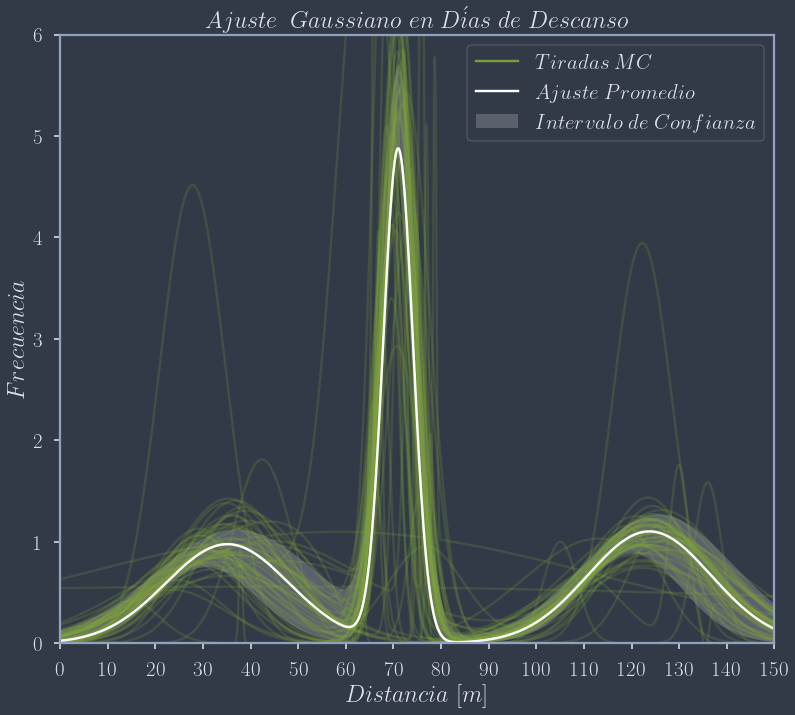

In [18]:
#Hago 60 tiradas MC suponiendo 10 personas en el vagón para obtener una PDF de los días de descanso
params_descanso, fig = sim_mc(n_sim=dias_descanso, n_personas=20,  title = r'$Ajuste \; \;Gaussiano \;en \;D\acute{i}as\; de \; Descanso$')
p_descanso, cte_norm = normaliza(gaussianas, params_descanso) # Normalizo la distribución

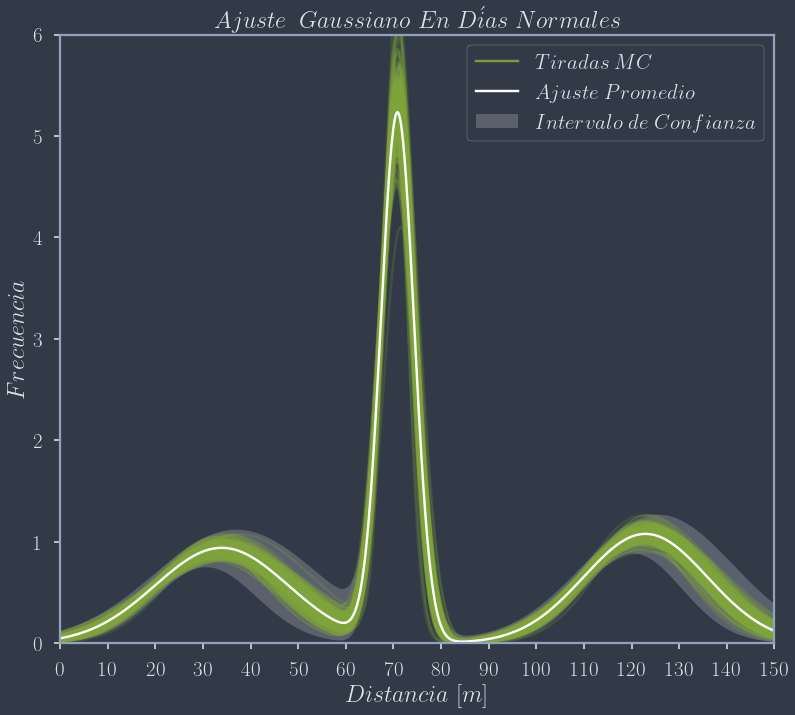

In [19]:
#Hago o mism para los días normales restantes, pero suponiendo que en estos hay 150 personas.
params_normales, fig = sim_mc(n_sim=dias_normales, n_personas=150, title = r'$Ajuste \; \;Gaussiano \;En \;D\acute{i}as\; Normales$')
p_normal, cte_norm = normaliza(gaussianas, params_normales)  #Normalizo la distribución

Ahora puedo calcular la probbilidad de que haya una persona entre 100 y 110m  en un día de descanso, y en un día normal:

In [20]:
p_dia_descanso = integra(p_descanso, 100,110) # probabilidad de que haya una persona entre (100,110) en día de descanso
p_dia_normal = integra(p_normal, 100,110) # probabilidad de que haya una persona entre (100,110) en día normal

De esta forma, la probabilidad de encontrar una persona en (100,110) ahora depende también de la probabilidad de que al escoger cualquier día del año, este sea día normal o no. Pensando esto de forma clásica, puedo usar la probabilidad condicional y el teorema de probabilidad total:

\textbf{Teorema (de probabilidad total):}
Sea $B_1,...,B_n$ una partición del espacio muestral tal que $P(B_i)\neq 0,\;i=1,...,n$. Para cualquier evento $A$,
$$P(A) = \sum_{i=1}^{n}P(A|B_i)P(B_i)$$

Así la probabilidad de que haya una persona entre 100 y 110m está dada por:
\begin{eqnarray*}
P(100\geq x \geq 110) &=& P(Escoger \; día \;de \; descanso)P(\exists \; una \; persona \; \epsilon \;(100,110) \; | \;Es \;día\; de\; descanso) \\
                     & &   + P(Escoger \; día \;normal)P(\exists \; una \; persona \; \epsilon\;(100,110) \;| \; Es \;día\; normal) \\   
                     &=& \left(\frac{No. \;días \;de\; descanso}{365}\right) \left(\frac{P(Sea\;día\;de\;descanso  \;y  \;\exists \;persona \; \epsilon \;(100,110) )}{P(Sea\;día\;de\;descanso)}\right) \\
                     & &   + \left(\frac{No. \;días \;normales}{365}\right) \left(\frac{P(Sea\;día\;normal  \;y  \;\exists \;persona \; \epsilon \;(100,110) )}{P(Sea\;día\;normal)}\right)
\end{eqnarray*}


In [21]:
p_dado_dia_desc = (365/dias_descanso)*p_dia_descanso   # probabilidad de que haya una persona entre (100,110) dado que es un día de descanso
p_dado_dia_normal = (365/dias_normales)*p_dia_normal # probabilidad de que haya una persona entre (100,110) dado que es un día normal

P = (dias_descanso/365)*p_dado_dia_desc + (dias_normales/365)*p_dado_dia_normal
md(f'Haciendo estas consideraciones, ahora la probabilidad total de encontrar a una persona entre 100 y 110 metros es {round(P,4)}')

Haciendo estas consideraciones, ahora la probabilidad total de encontrar a una persona entre 100 y 110 metros es 0.0759